In [26]:
%matplotlib inline
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
from google.colab import drive
drive.mount('/content/drive')

cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
dataset_root_dir= "/content/drive/My Drive/Paint.io/"

In [28]:
%pylab inline
import time
import os 

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import transforms

from PIL import Image
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
#vgg definition that conveniently let's you grab the outputs from any layer
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]

In [0]:
# gram matrix and loss
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        G.div_(h*w)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return(out)

In [31]:
# pre and post processing for images
img_size = 512 
prep = transforms.Compose([transforms.Scale(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:220: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [0]:
image_dir = dataset_root_dir + '/Images/'
model_dir = dataset_root_dir + '/Models/'
vgg = VGG()
vgg.load_state_dict(torch.load(model_dir + 'vgg_conv.pth'))
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

In [34]:
#load images, ordered as [style_image, content_image]
name = ['cezanne.jpg','ukiyo.jpg','vangogh.jpg']
out1=[]
for j in range(0,3):
    paintername = name[j]
    t=str(1)
    img_dirs = [image_dir,image_dir] 
    img_names = [name[j],t+'.png']
    imgs = [Image.open(img_dirs[i] + name) for i,name in enumerate(img_names)]
    imgs_torch = [prep(img) for img in imgs]
    if torch.cuda.is_available():
        imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
    else:
        imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
    style_image, content_image = imgs_torch

    # opt_img = Variable(torch.randn(content_image.size()).type_as(content_image.data), requires_grad=True) #random init
    opt_img = Variable(content_image.data.clone(), requires_grad=True)

    style_layers = ['r11','r21','r31','r41','r51'] 

    content_layers = ['r42','r32','r22']
    loss_layers = style_layers + content_layers
    loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
    if torch.cuda.is_available():
        loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
        
    #these are good weights settings:
    style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
    content_weights = [1e0,1e0,1e0]
    weights = style_weights + content_weights

    #compute optimization targets
    style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
    content_targets = [A.detach() for A in vgg(content_image, content_layers)]
    targets = style_targets + content_targets


    #run style transfer
    max_iter = 500
    show_iter = 100
    optimizer = optim.LBFGS([opt_img]);
    n_iter=[0]

    while n_iter[0] <= max_iter:

        def closure():
            optimizer.zero_grad()
            out = vgg(opt_img, loss_layers)
            layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
            loss = sum(layer_losses)
            loss.backward()
            n_iter[0]+=1
            #print loss
            if n_iter[0]%show_iter == (show_iter-1):
                print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))
    #             print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
            return loss
        
        optimizer.step(closure)

    out1.append(postp(opt_img.data[0].cpu().squeeze()))

Iteration: 100, loss: 366936.093750
Iteration: 200, loss: 238602.062500
Iteration: 300, loss: 199514.437500
Iteration: 400, loss: 185054.453125
Iteration: 500, loss: 177620.656250
Iteration: 100, loss: 1208545.125000
Iteration: 200, loss: 564707.250000
Iteration: 300, loss: 406683.000000
Iteration: 400, loss: 337328.156250
Iteration: 500, loss: 300202.531250
Iteration: 100, loss: 1027202.625000
Iteration: 200, loss: 603424.187500
Iteration: 300, loss: 489110.500000
Iteration: 400, loss: 441101.781250
Iteration: 500, loss: 418041.750000


<b> We used this input image and transfer style from 3 painters: Cezanne, Ukiyo and Vangogh</b>

(-0.5, 255.5, 255.5, -0.5)

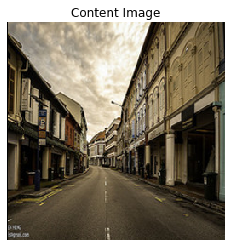

In [64]:
plt.imshow(Image.open(image_dir+'1.png'))
plt.title('Content Image')
plt.axis('off')

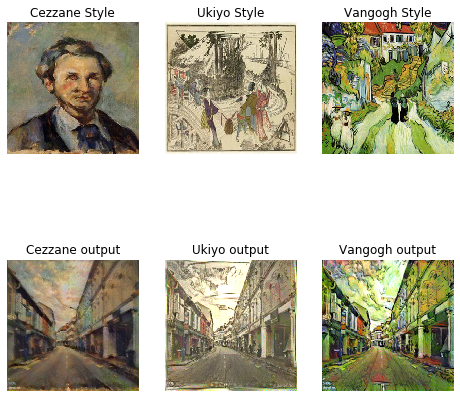

In [66]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(8,8))
plt.axis('off')
ax1 = plt.subplot(231)
ax1.axis('off')
ax2 = plt.subplot(232)
ax2.axis('off')
ax3 = plt.subplot(233)
ax3.axis('off')
ax4 = plt.subplot(234)
ax4.axis('off')
ax5 = plt.subplot(235)
ax5.axis('off')
ax6 = plt.subplot(236)
ax6.axis('off')

ax1.imshow(Image.open(image_dir+'cezanne.jpg'))
ax1.title.set_text('Cezzane Style')
ax2.imshow(Image.open(image_dir+'ukiyo.jpg'))
ax2.title.set_text('Ukiyo Style')
ax3.imshow(Image.open(image_dir+'vangogh.jpg'))
ax3.title.set_text('Vangogh Style')
ax4.imshow(out1[0])
ax4.title.set_text('Cezzane output')
ax5.imshow(out1[1])
ax5.title.set_text('Ukiyo output')
ax6.imshow(out1[2])
ax6.title.set_text('Vangogh output')


